In this notebook, we'll work through an example of portfolio optimization. The exercises we do are related to the work by Harry Markowitz, a UChicago grad and winner of the Nobel prize in economics in 1990.

In [1]:
# always import all necessary libraries at the top of the file
import numpy as np
import scipy.optimize
from matplotlib import pyplot as plt
import pandas as pd

# Data

In this folder, there should be a file called `dataAssets.csv`. Make sure that you have this file. Run the code below to load the data into numpy arrays.

In the matrix of prices, each row corresponds to a day. The columns correspond, (in order,) to the S&P 500 index, USD index, crude oil index, HYG index, and U.S. 10-yr Treasury index.

In [2]:
url = 'https://raw.githubusercontent.com/jmbejara/bfi-reu-2019/master/dataAssets.csv'
data_assets = pd.read_csv(url, parse_dates=['date'])

In [3]:
data_assets.head()

,date,sp500,USD_index,crude_oil,HYG,treasury_10yr
0,2013-08-07,1690.91,81.287,87.83,91.36,2.5986
1,2013-08-08,1697.48,80.977,87.50,91.56,2.5892
2,2013-08-09,1691.42,81.126,87.95,91.57,2.5784
3,2013-08-12,1689.47,81.333,88.19,91.49,2.6206
4,2013-08-14,1685.39,81.711,88.47,91.31,2.7136


In [4]:
# For practice, we'll use Numpy. In the future, you should use Pandas
prices = data_assets.iloc[:,1:].values
dates = data_assets.iloc[:,0].values

# Portfolio

 - (1) Calculate log return rates using the given price data (log of the gross returns). Multiply by 100 so that the returns are in percetages.

In [5]:
rets = np.log(prices[1:,:]/prices[:-1,:]) * 100

- (2) Form a portfolio of data, equally split between the S&P 500 and the Oil Index.

In [6]:
portfolio = 0.5 * rets[:,0] + 0.5 * rets[:,2]

- (3) Calculate the 20th percentile of the return history on this portfolio. (Use `numpy.percentile`. Be sure to specify in terms of percetages---between 0 and 100.)

In [7]:
percent = 30
np.percentile(portfolio, percent)

-0.3353242451831822

 - (4) Use `matplotlib.pyplot.hist` to create a histogram of the returns on this portfolio. Also plot a separate figure with a histogram of the returns for the S&P 500 and for Oil on the same plot. Use labels to distinguish them. You should probably plot Oil first, or at least set the alpha (transparancy) on each plot to something like 0.5. Be sure to include a legend.

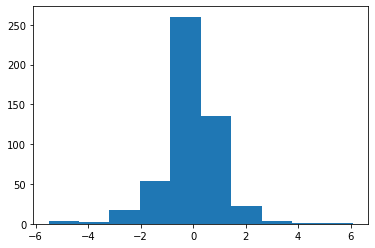

In [8]:
plt.hist(portfolio);

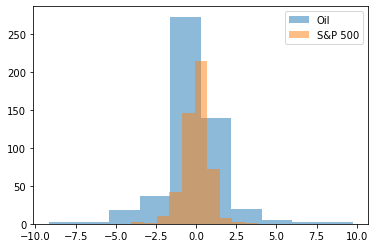

In [9]:
plt.hist(rets[:,2], alpha=.5, label='Oil');
plt.hist(rets[:,0], alpha=.5, label='S&P 500');
plt.legend()

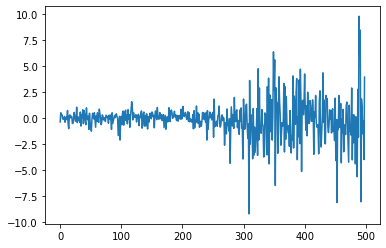

In [10]:
plt.plot(rets[:,2])

Below is an example of how you would use Pandas. Note the index provides automatic data alignment. This is an important feature that can help reduce errors.

In [11]:
# This is how you would construct returns with Pandas
df = data_assets.copy()
df = df.set_index('date')
df_ret = df.apply(lambda col: col/col.shift(1)-1)

In [12]:
df_ret.head()

,sp500,USD_index,crude_oil,HYG,treasury_10yr
date,,,,,
2013-08-07,NaN,NaN,NaN,NaN,NaN
2013-08-08,0.003885,-0.003814,-0.003757,0.002189,-0.003617
2013-08-09,-0.003570,0.001840,0.005143,0.000109,-0.004171
2013-08-12,-0.001153,0.002552,0.002729,-0.000874,0.016367
2013-08-14,-0.002415,0.004648,0.003175,-0.001967,0.035488


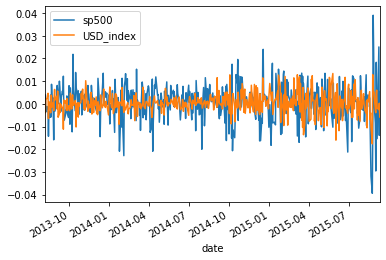

In [13]:
df_ret[['sp500', 'USD_index']].plot()

In [14]:
df_ret.mean()

sp500            0.000321
USD_index        0.000332
crude_oil       -0.001140
HYG             -0.000103
treasury_10yr   -0.000091
dtype: float64

In [15]:
df_ret.std()

sp500            0.008147
USD_index        0.004511
crude_oil        0.017814
HYG              0.003559
treasury_10yr    0.021162
dtype: float64

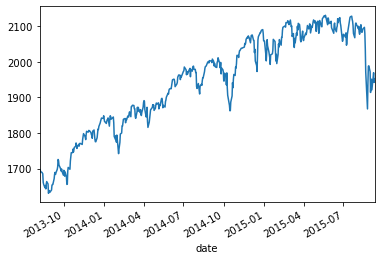

In [16]:
df.sp500.plot()

# Mean-Variance Efficient Portfolios


In this application, we replicate the Markowitz model of portfolio optimization. This model is a model of investor behavior. It models an investor you prefers a portfolio that has higher expected returns and lower variance, *ceteris paribus*. The result of this assumption is that investors (1) choose diversified portfolios and (2) that there exist on a "mean-variance efficient frontier" along which investors choose their portfolios. That is, there are some portfolios that consist of some combinations of assets that are strictly dominated by other combinations of assets. This model  formalizes the notion that an investor should not "put all of his/her eggs in one basket" as well as  the tradeoff between risk and return.

(Note: There are other important lessons that we can learn from this model, but they are beyond the scope of this class. For one, you may search Google for the concept of the "two-portfolio separation theorem." Also note that we are excluding any "risk-free" short-term assets from our analysis here. Also note that Markowitz won the Nobel prize in economics in 1990 for this analysis.)

Suppose that $\mu$ is a column vector of the means of each asset and suppose that $\Sigma$ is the associated variance-covariance matrix. Now, suppose that we create a column vector of weights $w$ that tells us the fraction of our wealth that we invest in each asset. Then, the formulas in matrix notation for the mean and variance of the resulting portfolio are
$$
\mu_p = \mu' w
$$
and
$$
\sigma_p^2 = w' \Sigma w
$$
respectively.


### Global Minimum Variance Portfolio

We'll first start by finding a particular portfolio called the "global minimum variance" portfolio (assuming the absence of a risk-free asset--why?). 

**Discussion** 

 * What is a risk-free asset? Why am I assuming that one doesn't exist?


Consider a portfolio allocation vector, `w`, which sums to 1 and allocates a fraction of the portfolio to each of the 5 securities. For example

    w = np.array([.2, .2, .2, .2, .2])
    
allocates 20% to each asset.

In [17]:
# You may find that this code is helpful for viewing
# the arrays. Suppress will suppress scientific notation
# and precision sets the number of digits to print to
# the screen
np.set_printoptions(precision=2, suppress=True)

 - (1) First, calculate the covariance matrix of the assets. Save it to a variable called `Sigma`. Be sure to set the option of the covariance function to `rowvar=False`, since each column in our matrix is a variable, not each row. Alternatively, you could transpose the matrix.

In [18]:
np.std(rets, axis=0)

array([0.81, 0.45, 1.78, 0.36, 2.11])

In [19]:
Sigma = np.cov(rets, rowvar=False)
Sigma

array([[ 0.67,  0.04,  0.35,  0.19,  0.58],
       [ 0.04,  0.2 , -0.11,  0.  ,  0.22],
       [ 0.35, -0.11,  3.18,  0.2 ,  0.79],
       [ 0.19,  0.  ,  0.2 ,  0.13,  0.06],
       [ 0.58,  0.22,  0.79,  0.06,  4.46]])

In [20]:
np.cov(rets.T)

array([[ 0.67,  0.04,  0.35,  0.19,  0.58],
       [ 0.04,  0.2 , -0.11,  0.  ,  0.22],
       [ 0.35, -0.11,  3.18,  0.2 ,  0.79],
       [ 0.19,  0.  ,  0.2 ,  0.13,  0.06],
       [ 0.58,  0.22,  0.79,  0.06,  4.46]])

 - (2)
Write an in-line function (a `lambda` function) that calculates the return variance for the allocation using the formula
$$
w' \Sigma w.
$$
Call the function `w`. That is, save the function to a variable called `w`.
Try out your new function using the following portfolio weights:

    w = np.array([1,0,0,0,0])
    w = np.array([.2, .2, .2, .2, .2])
    w = np.array([.4, 0, .2, .2, .2])

In [21]:
f = lambda w: w.transpose() @ Sigma @ w

In [22]:
w = np.array([1,0,0,0,0])
f(w)

0.6652650184323119

In [23]:
w = np.array([.2, .2, .2, .2, .2])
f(w)

0.5313706492829182

In [24]:
w = np.array([.4, 0, .2, .2, .2])
f(w)

0.6807163918909426

 - (3) Write a constraint function called `con`. This takes in the vector of portfolio weights `w` and returns the difference between 1 and the sum of the portfolio weights. The purpose is that if the weights sum to one, then the function returns a zero. The zero indicates that the contraint holds.

In [25]:
con = lambda w: np.sum(w) - 1

 - (4) Minimize this portfolio variance, subject to the constraint that portfolio weights add to 1. 
 
To do this, check out the available constrained optimizers listed in the Scipy documentation: https://docs.scipy.org/doc/scipy/reference/optimize.html

Use sequential least squares: `scipy.optimize.fmin_slsqp`. Set the desired accuracy to `acc=1e-09` and set the option `iprint=2` so that the optimizer will display information at each iteration of the algorithm. You will need to set an initial guess for the optimizer to start from. Set the initial guess to

    w0 = np.array([.2, .2, .2, .2, .2])
    
Save the final results into a new variable called `wstar`.

In [26]:
w0 = np.array([.2, .2, .2, .2, .2])
wstar = scipy.optimize.fmin_slsqp(f, w0, f_eqcons=con, acc=1e-09, iprint=2)
wstar

  NIT    FC           OBJFUN            GNORM
    1     7     5.313706E-01     3.113951E+00
    2    15     1.447132E-01     7.891362E-01
    3    23     1.183773E-01     5.918720E-01
    4    30     8.310490E-02     3.783806E-01
    5    37     7.926658E-02     3.658035E-01
    6    44     7.267062E-02     3.249795E-01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0726706152704004
            Iterations: 6
            Function evaluations: 44
            Gradient evaluations: 6


array([-0.13,  0.37,  0.  ,  0.76,  0.01])

 - (5) Test your newly optimized function. Evaluate the covariance of the portfolio at `wstar` and 
    
    `wstar + np.array([0.1, 0, 0, 0, -0.1])`

and

    wstar - np.array([0.1, 0, 0, 0, -0.1])
    
The perturbation will ensure that the constraint still holds. Does `wstar` appear to be an minimum?

**Discussion:**

 * What do I mean when I say that the "perturbation will ensure that the constraint still holds"? 
 * Why is it important for this constraint to hold?

In [27]:
f(wstar)

0.0726706152704004

In [28]:
f(wstar + np.array([0.1, 0, 0, 0, -0.1]))

0.11231138935742016

In [29]:
f(wstar - np.array([0.1, 0, 0, 0, -0.1]))

0.11231388872759333

### Mean-Variance Efficient Portfolios

We now consider the case of constructing a portfolio that has minimum variance among all possible portfolios that have a "target" expected return. To do this, let's complete the following steps.

 - (1) Compute the means of the asset returns and the variance-covariance matrix. Save the means as the numpy array `mu`. Save the variance-covariance matrix as the numpy array `Sigma`. 

In [30]:
# did this above
Sigma

array([[ 0.67,  0.04,  0.35,  0.19,  0.58],
       [ 0.04,  0.2 , -0.11,  0.  ,  0.22],
       [ 0.35, -0.11,  3.18,  0.2 ,  0.79],
       [ 0.19,  0.  ,  0.2 ,  0.13,  0.06],
       [ 0.58,  0.22,  0.79,  0.06,  4.46]])

In [31]:
mu = np.mean(rets, axis=0)
mu

array([ 0.03,  0.03, -0.13, -0.01, -0.03])

 - (2) Solve for the optimal portfolio that solves the following contrained minimization problem given a target expected portfolio return of $\mu_p = 0.01$.
 
\begin{align*}
\min_{w} \quad & w' \Sigma w \\
\text{s.t.} \quad & w' \mu = \mu_p \\
& w' \mathbb 1 = 1 
\end{align*}
where $\mathbb 1$ is a conforming vector of ones. For an initial guess for the optimizer, choose a portfolio of equal weights to each asset (a $5 \times 1$ vector of the value $0.2$).

Use `scipy.optimize.fmin_slsqp`. In order to incorporate two constraints, carefully read the documentation regarding the keyword argument `eqcons`.

Save the optimal set of portfolio weights as `wstar`. Calculate the variance of this optimal portfolio. Verify that the sum of the weights is numerically close to 1.

In [32]:
var_func = lambda w: w.transpose() @ Sigma @ w
mu_target = 0.01
con_mean = lambda w: w @ mu - mu_target
con_port = lambda w: w @ np.ones((5,1)) - 1
eqcons = [con_mean, con_port]

w0 = np.array([.2, .2, .2, .2, .2])
wstar = scipy.optimize.fmin_slsqp(var_func, w0, eqcons=eqcons, iprint=2)
wstar

  NIT    FC           OBJFUN            GNORM
    1     7     5.313706E-01     3.113951E+00
    2    15     2.650969E-01     1.615485E+00
    3    22     8.549178E-02     4.278800E-01
    4    29     8.005873E-02     3.149590E-01
    5    36     7.993000E-02     3.148438E-01
    6    43     7.991447E-02     3.149401E-01
    7    50     7.990880E-02     3.151721E-01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.07990879699726343
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7


array([-0.04,  0.47, -0.02,  0.61, -0.01])

In [33]:
sum(wstar)

1.0

In [34]:
var_func(wstar)

0.07990879699726343

 - (3) Use `numpy.linspace` to create a vector of `N` values equally spaced from -0.01 to 2. Call this vector `mean_grid`. For each value in this mean grid with `N=100`, solve the above maximization problem with the value of the mean grid as the target expected portfolio return $\mu_p$. For each solution, record the value of the objective. That is, record the minimal portfolio return variance needed to acheive the desired expected portfolio return. Plot the two vectors that result on a plot with the x-axis labelled 'Portfolio Return Variance', the y-axis labelled 'Mean Portfolio Return', and the title of plot as 'Mean-Variance Efficient Frontier'.

In [35]:
N = 100
mean_grid = np.linspace(-0.01, 2, N)
var_grid = np.zeros(N)

In [36]:
for i in range(N):
    mu_target = mean_grid[i]
    var_func = lambda w: w.transpose() @ Sigma @ w
    con_mean = lambda w: w @ mu - mu_target
    con_port = lambda w: w @ np.ones((5,1)) - 1
    eqcons = [con_mean, con_port]
    w0 = np.array([.2, .2, .2, .2, .2])
    wstar = scipy.optimize.fmin_slsqp(var_func, w0, eqcons=eqcons, acc=1e-09, 
                                      iprint=0)
    var_grid[i] = var_func(wstar)

Text(0.5, 1.0, 'Mean-Variance Efficient Frontier')

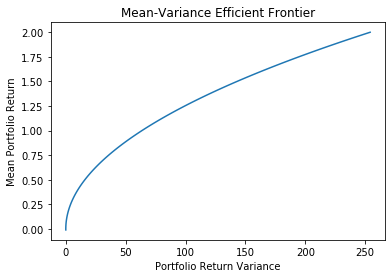

In [37]:
plt.plot(var_grid, mean_grid)
plt.xlabel('Portfolio Return Variance')
plt.ylabel('Mean Portfolio Return')
plt.title('Mean-Variance Efficient Frontier')

##  Bounding the Portfolio Weights 

Suppose we take the problem from before and add a new set of constraints. Let's add bounds on the portfolio weights such that no weight may be less than zero. We can interpret this as a constraint that disallows "short-selling." In particular, solve the problem

\begin{align*}
\min_{w} \quad & w' \Sigma w \\
\text{s.t.} \quad & w' \mu = \mu_p \\
& w' \mathbb 1 = 1 \\
& w_i \geq 0 \quad \text{ for all } i=1,..,k.
\end{align*}

Use `scipy.optimize.fmin_slsqp` again. Check the documentation for information on how to include "bound constraints." https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_slsqp.html

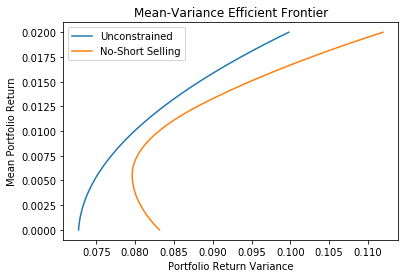

In [38]:
# SOLUTION
mu = np.mean(rets, axis=0)
Sigma = np.cov(rets, rowvar=False)

N = 100
mean_grid = np.linspace(0.0, .02, N)
var_grid = np.zeros(N)
var_grid_no_short = np.zeros(N)

no_short_bounds = [(0,np.inf), (0,np.inf), (0,np.inf), (0,np.inf), (0,np.inf)]

for i in range(N):
    mu_target = mean_grid[i]
    var_func = lambda w: w.transpose() @ Sigma @ w
    con_mean = lambda w: w @ mu - mu_target
    con_port = lambda w: w @ np.ones((5,1)) - 1
    eqcons = [con_mean, con_port]
    w0 = np.array([.2, .2, .2, .2, .2])
    wstar = scipy.optimize.fmin_slsqp(var_func, w0, eqcons=eqcons, acc=1e-09, 
                                      iprint=0)
    var_grid[i] = var_func(wstar)
    wstar = scipy.optimize.fmin_slsqp(var_func, w0, 
                                      eqcons=eqcons,
                                      bounds=no_short_bounds,
                                      acc=1e-09, 
                                      iprint=0)
    var_grid_no_short[i] = var_func(wstar)

plt.plot(var_grid, mean_grid, label='Unconstrained')
plt.plot(var_grid_no_short, mean_grid, label='No-Short Selling')
plt.xlabel('Portfolio Return Variance')
plt.ylabel('Mean Portfolio Return')
plt.title('Mean-Variance Efficient Frontier')
plt.legend();